In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import image
from matplotlib import pyplot as plt
import joblib

def load_file(datapath):
    with open(datapath, 'rb') as file:
        data = joblib.load(file)
        file.close()
    return data

# Analysis of Tiling Effect

When inference maps are visualised, a very obvious tiling effect can be seen, with rough edges and seemingly consistent areas. Additionally, the temperature range of <10 to >40 seems significantly too broad, given that all time windows are from summer months and true temperatures never exceed 35°C. 

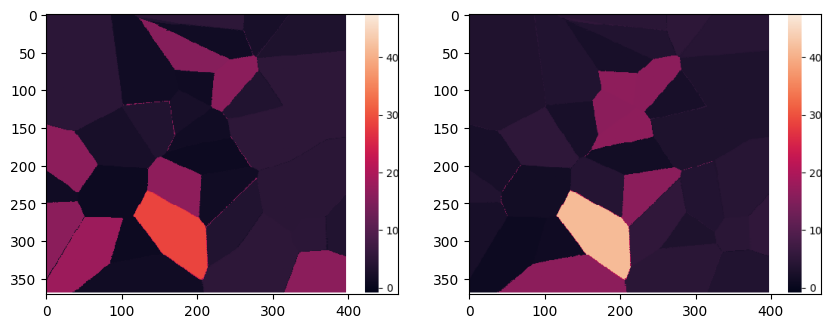

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
imgpath = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/QRF Inference/2023-11-28_16.30/TempMaps/tempmap_12.png'
ax[0].imshow(image.imread(imgpath))
imgpath = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/QRF Inference/2023-11-28_16.30/TempMaps/tempmap_13.png'
ax[1].imshow(image.imread(imgpath))


### Plot of feature variables - RUN 1
The aim of plotting the feature variables is to see which of them most resemble the tiled pattern we see above.

In [10]:
resultdir = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/QRF Inference/2023-11-28_16.13/'
resultpath = os.path.join(resultdir, os.path.basename(os.path.normpath(resultdir)) + '.json')
inferencedatapath = 'C:/Users/ushe/Documents/LinuxDownload/mb_4_multi_stations_xy_N02.00m_palmhumi.json'
palmfile = os.path.basename(inferencedatapath).split('_palmhumi')[0]

# DATA
results = load_file(resultpath)
inferencedata = load_file(inferencedatapath)
palmboundary = load_file(f'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/PALM/{palmfile}_boundary.z')


# SPATIAL FEATURES
spatial_features = ['altitude', 'buildings', 'buildings_10', 'buildings_30', 'buildings_100', 'buildings_200', 
                    'buildings_500', 'forests', 'forests_10', 'forests_30', 'forests_100', 'forests_200', 
                    'forests_500', 'pavedsurfaces', 'pavedsurfaces_10', 'pavedsurfaces_30', 'pavedsurfaces_100', 
                    'pavedsurfaces_200', 'pavedsurfaces_500', 'surfacewater', 'surfacewater_10', 'surfacewater_30',
                    'surfacewater_100', 'surfacewater_200', 'surfacewater_500', 'urbangreen', 'urbangreen_10', 
                    'urbangreen_30', 'urbangreen_100', 'urbangreen_200', 'urbangreen_500', 'humidity', 
                    'irradiation', 'moving_average', 'temperature']

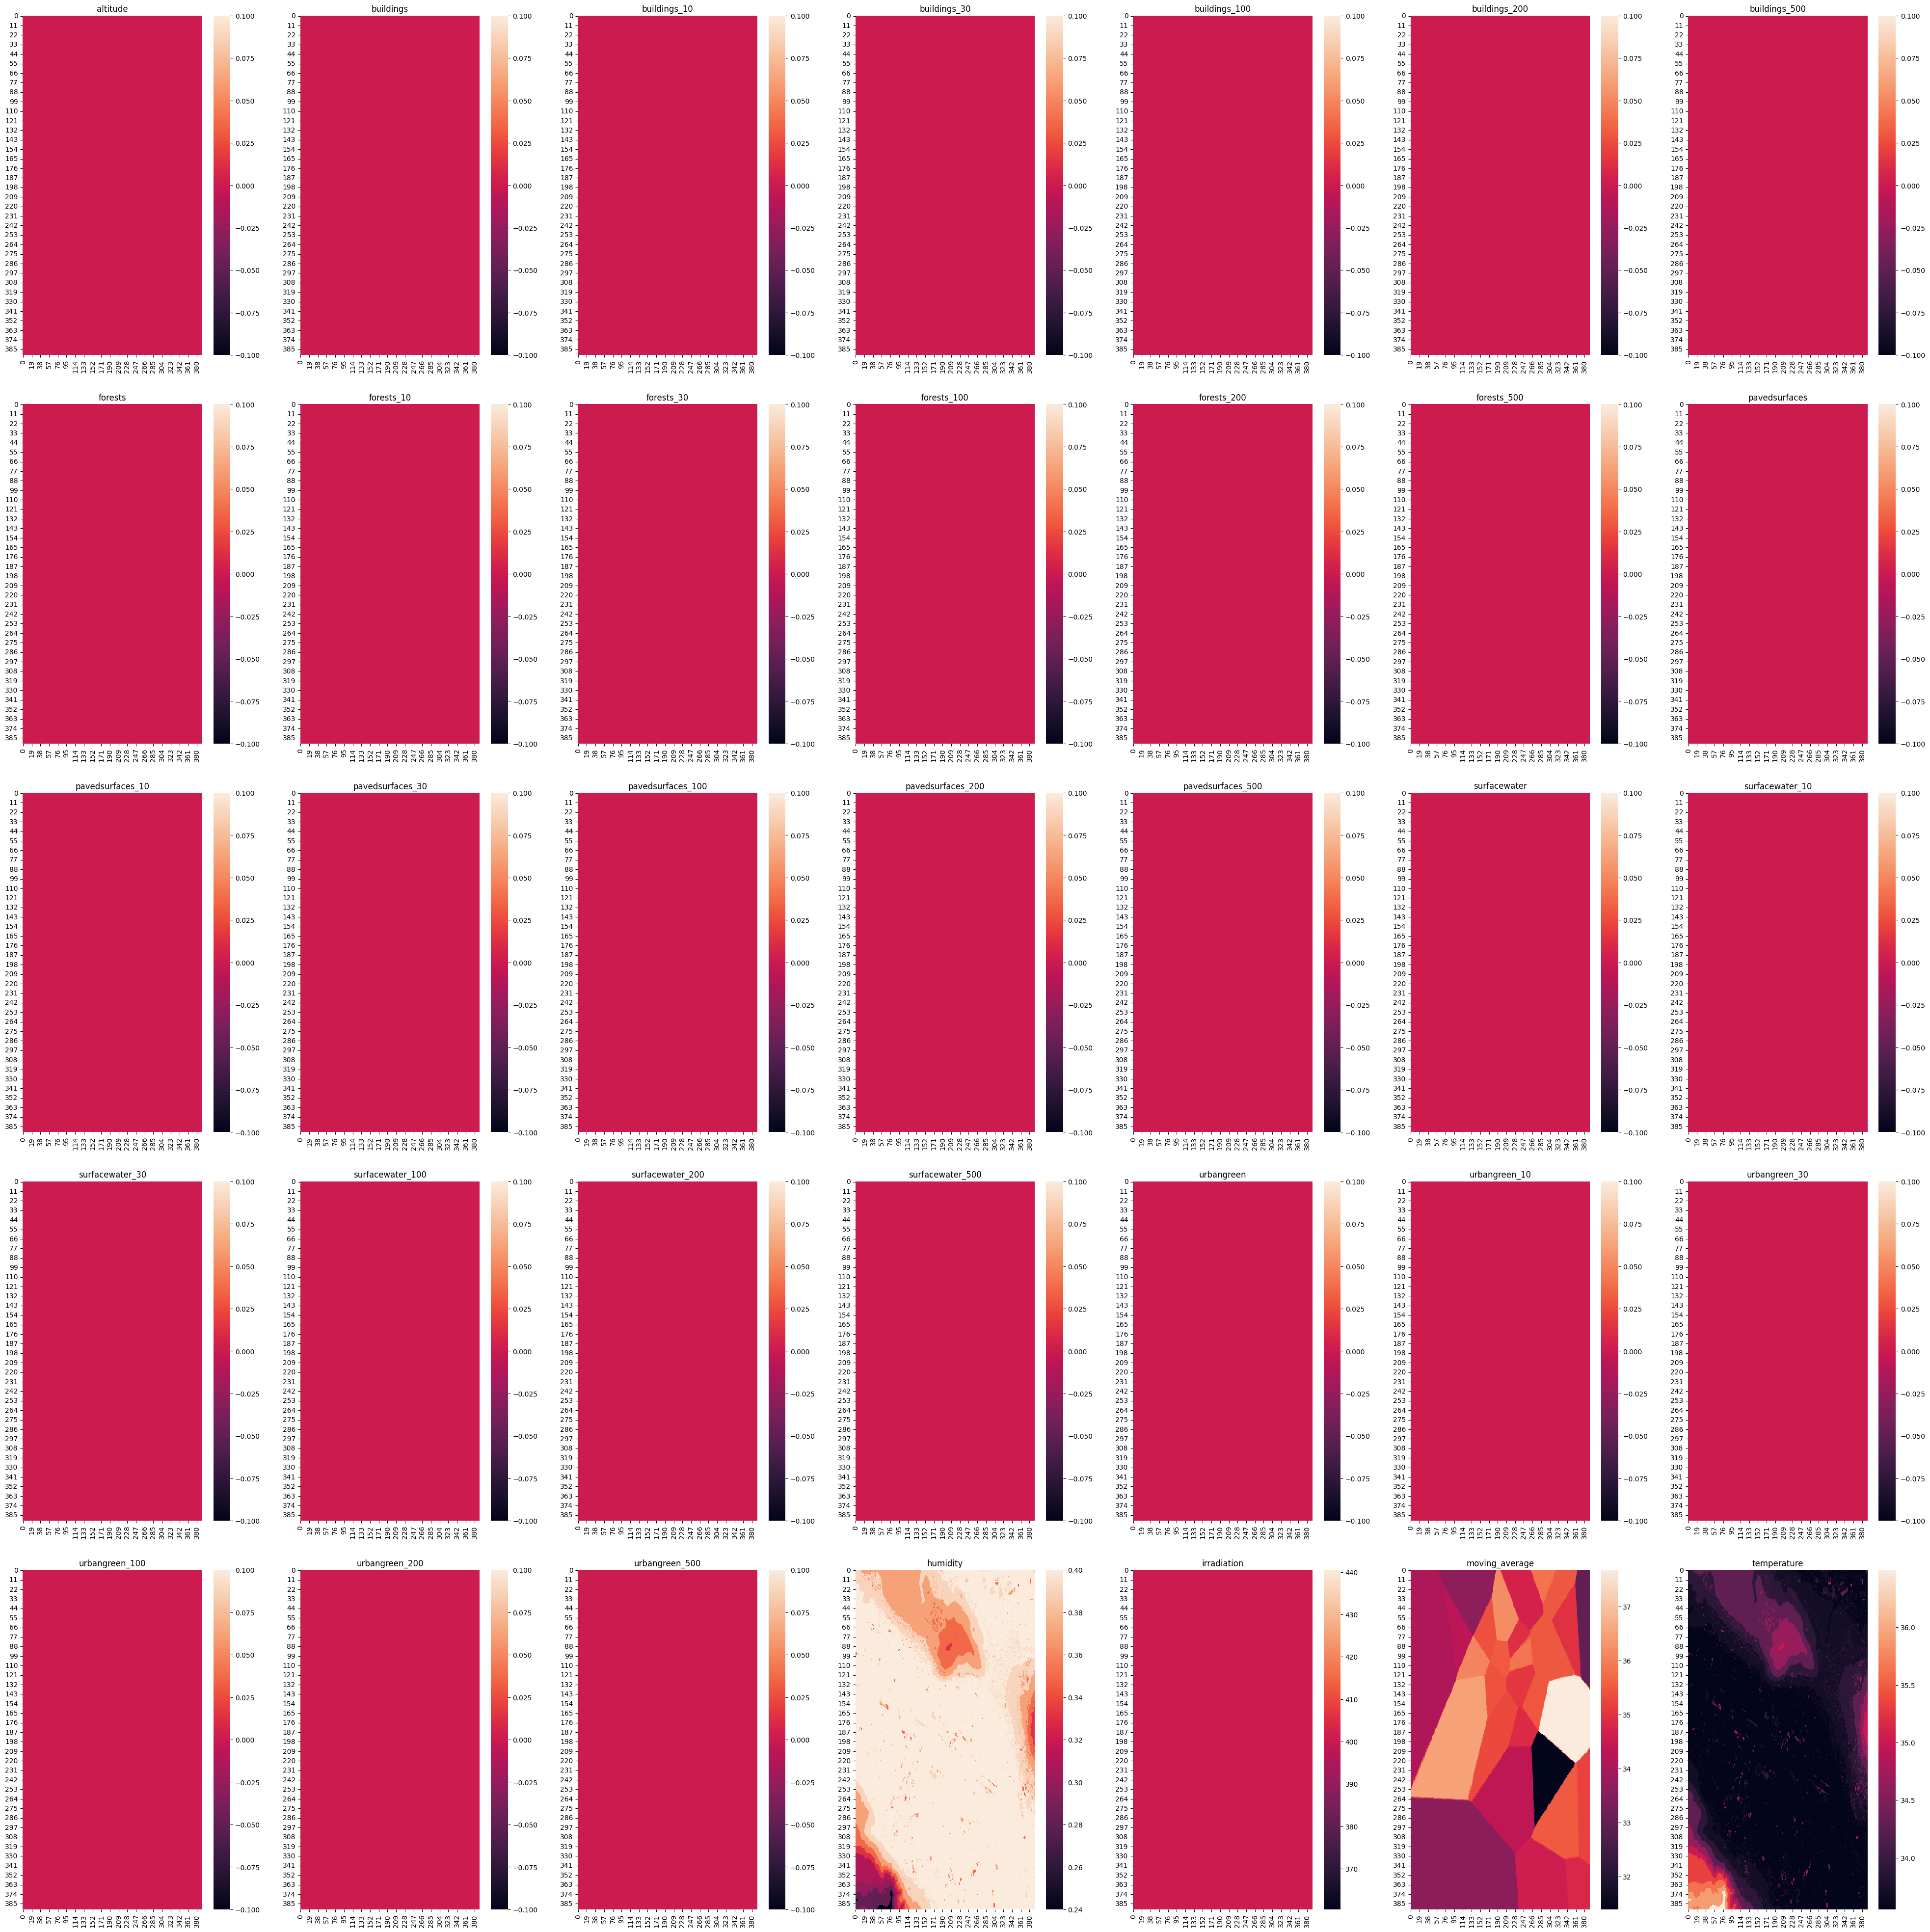

In [11]:
fig, axs = plt.subplots(5, 7, figsize=(40,40))
for i, feature in enumerate(spatial_features):
    ax = sns.heatmap(inferencedata[feature][0, :, :], ax=axs[i//7, i%7])
    ax.set_title(feature)
fig.tight_layout(pad=3.0)

Geofeatures seem to be unfilled - check with buildings

In [5]:
import os
import rasterio
geopath = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/geodata'
buildings = rasterio.open(os.path.join(geopath, 'buildings.tif'))
pavedsurfaces = rasterio.open(os.path.join(geopath, 'pavedsurfaces.tif'))

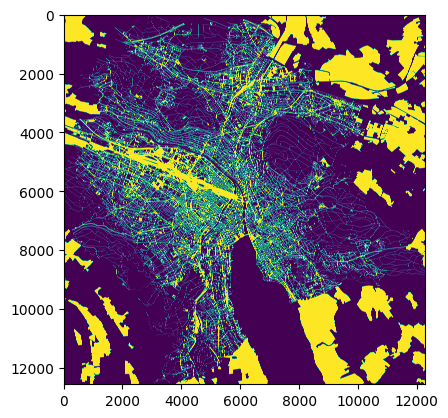

In [6]:
pavedsurfaces_img = pavedsurfaces.read()
plt.imshow(pavedsurfaces_img[0, :, :])

In [ ]:
geo_N = pavedsurfaces.meta['transform'][5]  # gives northern boundary
geo_W = pavedsurfaces.meta['transform'][2]  # gives western boundary
# transform to LV95 coordinates
geo_N += 1000000
geo_W += 2000000
geo_S = geo_N - pavedsurfaces.shape[1]
geo_E = geo_W + pavedsurfaces.shape[0]
featuremap = pavedsurfaces.read()
featuremap[featuremap == -9999] = 0

In [10]:
pavedsurfaces.meta['transform'][2]

677252.136

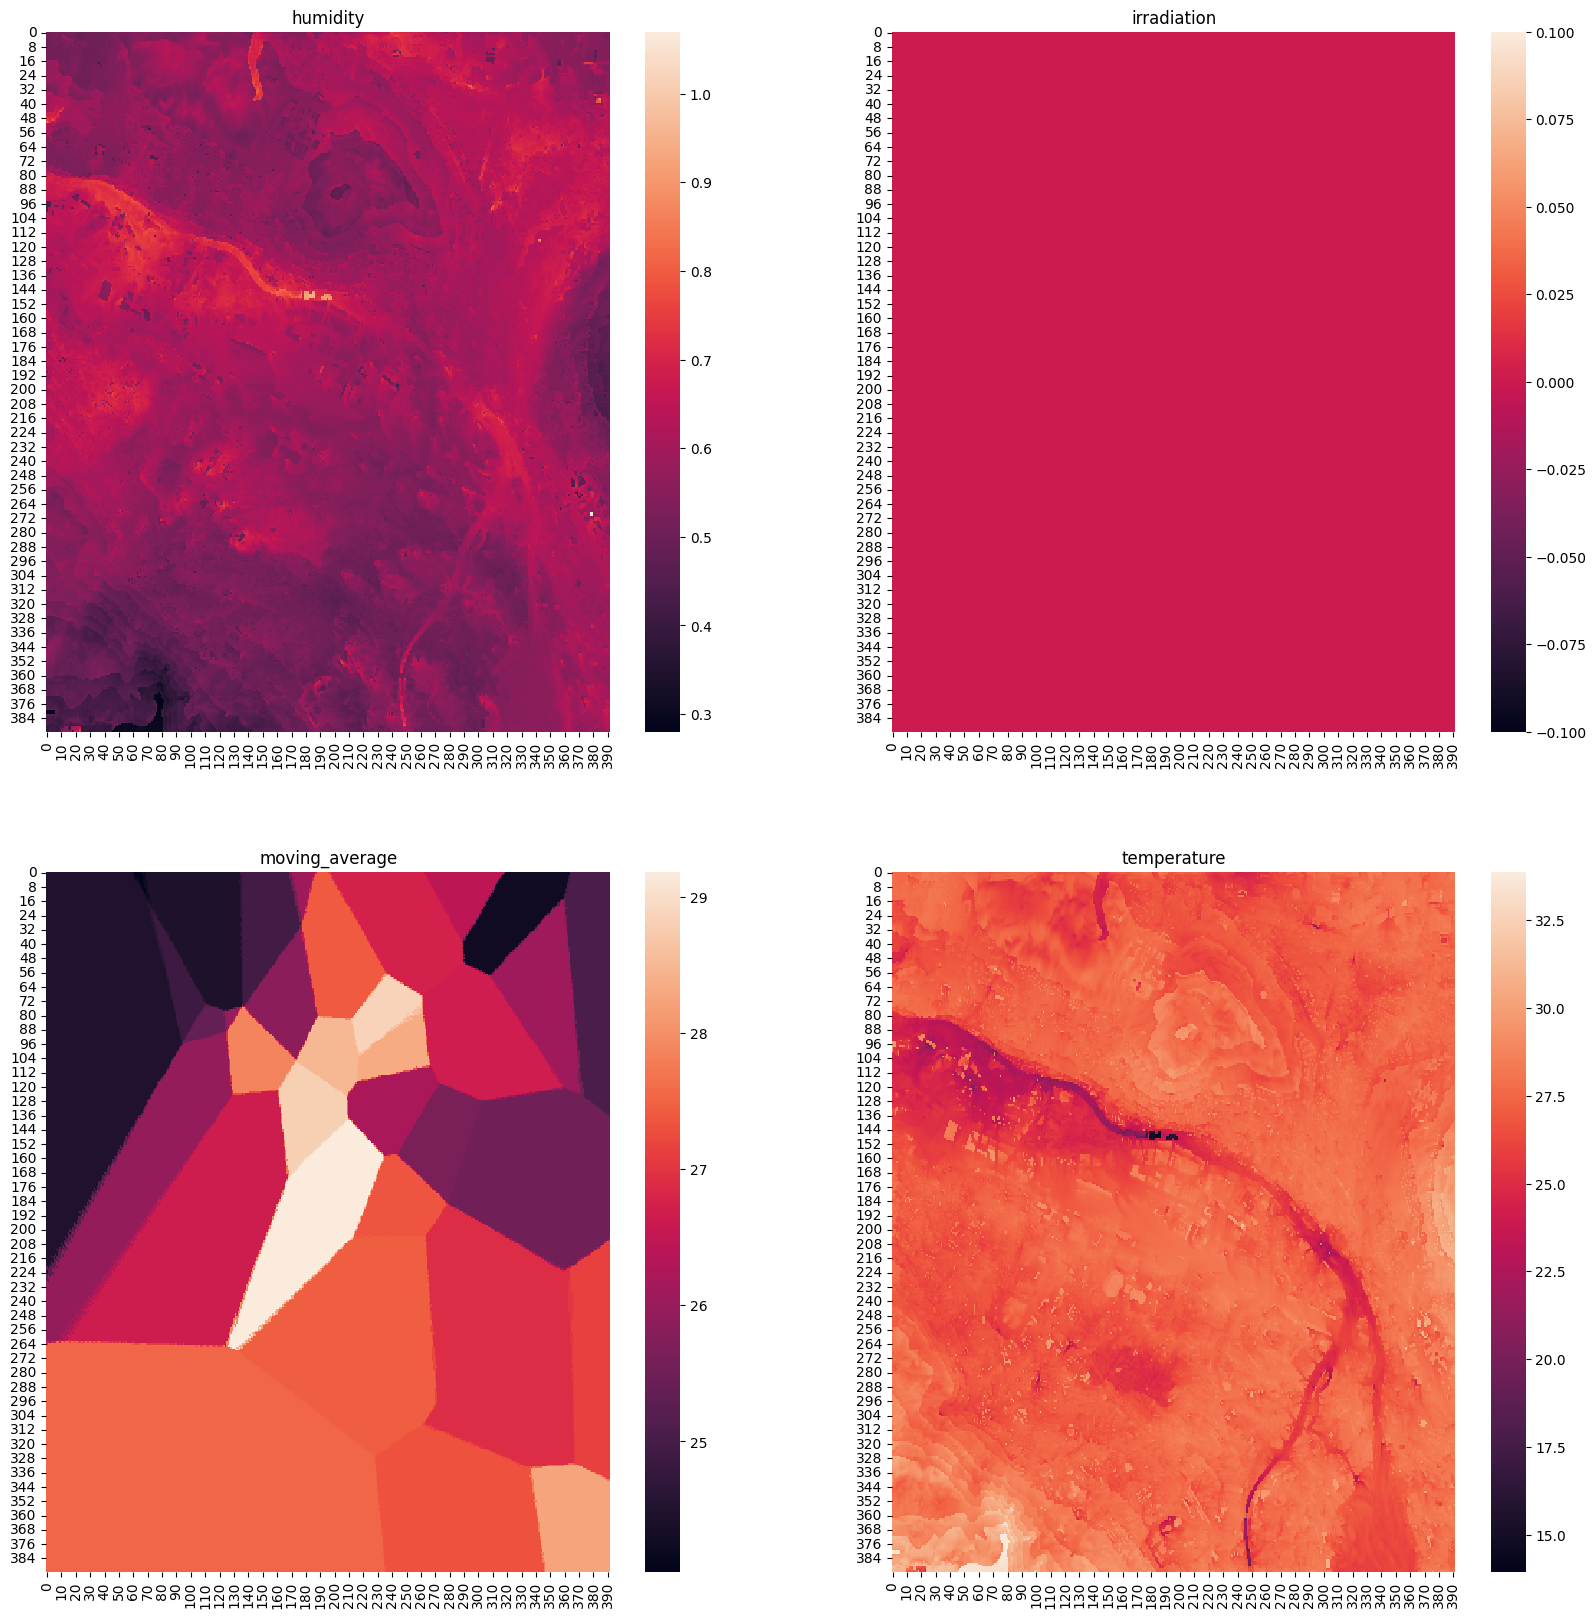

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
features = ['humidity', 'irradiation', 'moving_average', 'temperature']
for feature in features:
    ax = sns.heatmap(inferencedata[feature][9, :, :], ax=axs[features.index(feature)//2, features.index(feature)%2])
    ax.set_title(feature)

It is evident that the tiling is coming from the moving average feature.

In [20]:
def var_replacement(xTest, variable='moving_average', type='uniform'):
    '''
    Random temp replacement for moving average temperature with three method options: either fill using a uniform value,
    a gradient from lowest to highest value or a four-square pattern.
    '''
    shape = xTest[variable].shape
    y = shape[1]
    x = shape[2]
    replacement = np.zeros(shape)
    if type == 'uniform':
        replacement = np.full(shape, 30)
    elif type == 'gradient':
        max = np.nanmax(xTest[variable])
        min = np.nanmin(xTest[variable])
        step = (max-min)/y
        for row in range(y):
            replacement[:, row] = [min + (step*row)]*x
    elif type == 'squares':
        xmid = int(x/2)
        ymid = int(y/2)
        max = np.nanmax(xTest[variable])
        min = np.nanmin(xTest[variable])
        replacement[:, :xmid, :ymid] = min
        replacement[:, xmid:, :ymid] = min + (max-min)/3
        replacement[:, :xmid, ymid:] = min + ((max-min)/3)*2
        replacement[:, xmid:, ymid:] = min + ((max-min)/3)*3

    xTest[variable] = replacement
    return xTest

def load_inference_data(datapath, ):
    data = load_file(datapath)
    _ = data.pop('datetime')
    _ = data.pop('time')
    _ = data.pop('temperature')
    if 'moving average' in data.keys():
        data['moving_average'] = data['moving average']
        _ = data.pop('moving average')
    data = var_replacement(data)
    return data, data['moving_average'].shape

def load_file(datapath):
    with open(datapath, 'rb') as file:
        data = joblib.load(file)
        file.close()
    return data